# Philosopher trends over time

Wikipedia is a particularly great source because it documents any *impactful* philosophers (those that are worth having a page about, and thus are more likely to have an impact on the field -- not just individuals who have a PhD in philosophy) matters.

[sparql query](https://query.wikidata.org/)
```sql
SELECT ?personLabel ?dob
WHERE
{
  ?person wdt:P106 wd:Q4964182;
          wdt:P569 ?dob.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
```

wikidata IDs for common institutional professions:
- philosopher: Q4964182 (24,620 results, loads)
- politician: Q82955 (676,849 results, doesn't load)
- scientist: Q901 (31,874)
- priest: Q42603 (26491)
- athlete: Q2066131 (23692)
- artist: Q483501 (64994)
- entertainer: Q138858 (684)

(to count just `SELECT (COUNT(?person) AS ?count)`)

## Todo

plot ratio of #philosophers to |population|

## resources
- https://gapminder.org/data/documentation/gd003/
- https://www.worldometers.info/world-population/world-population-by-year/

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

font = {'family' : 'Arial',
       'weight' : 'regular',
       'size'   : 18}
plt.rc('font', **font)
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False

import re
pat = re.compile('^-?\d+') #integers (positive OR negative (BC)!)
df = pd.DataFrame()
careers = ('philosopher', 'athlete', 'scientist', 'artist')
for c in careers:
    _df = pd.read_csv(f'./data/{c}s.csv')
    _df = _df.drop(labels=['person'], axis=1) #drop sparql id
    _df['profession'] = c #remove s
    df = pd.concat((df, _df), ignore_index=True)
# people w/o dob have values like 't2246811766' or a URL
df = df[~df.dob.str.startswith('t')]
df = df[~df.dob.str.startswith('http')]
# lambda_dob = lambda s: int(re.match(pat, s)[0]) #not working
df.dob = df.dob.apply(lambda s: int(re.match(pat, s)[0])) #can't convert to datetime because of time range!
df = df.rename(columns={"personLabel": "name", 'dob':'yob'})
df = df[df.yob != 2000] # most people with yob=2000 is actually "born in 20th century"
df.head()

,name,yob,profession
0,John Amos Comenius,1592,philosopher
1,Umberto Eco,1932,philosopher
2,George Soros,1930,philosopher
3,Vinoba Bhave,1895,philosopher
4,Frédéric Bastiat,1801,philosopher


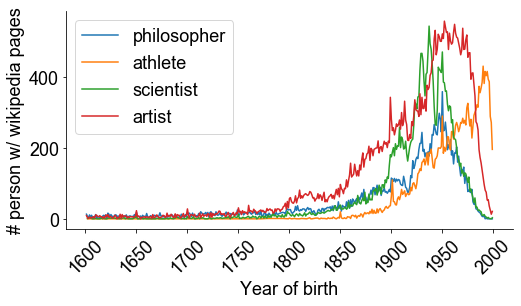

In [30]:
start_date, stop_date = 1600, 2000
# plt.figure(figsize=(8,4))
# plt.hist(np.array(df[df.yob > start_date].yob).flatten(), histtype='step', bins=100, lw=2)
# plt.xticks(rotation=45)
# plt.locator_params(axis="x", nbins=30)
# plt.yscale('log')
# plt.show()
careers = ('philosopher', 'athlete', 'scientist', 'artist')

plt.figure(figsize=(8,4))
for c in careers:
    _df = df[df.profession == c]
    plt.plot(_df[(_df.yob > start_date) & (_df.yob < stop_date)].groupby(['yob']).size(), label=c)
    
plt.xticks(rotation=45)
plt.locator_params(axis="x", nbins=10)
# plt.yscale('log')
plt.legend()
plt.xlabel('Year of birth');   plt.ylabel('# person w/ wikipedia pages')
plt.show()


In [188]:
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from collections import defaultdict

hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(url, headers=hdr)
page = urlopen(req)
soup = BeautifulSoup(page)

year2pop = defaultdict(list)
all_td = soup.find_all('td')
cols = ['Year','World Population','YearlyChange','NetChange','Density(P/Km²)','UrbanPop','UrbanPop %'] #copied and pasted from webpage
ix = 0
for i, el in enumerate(all_td):
    
    try: # if not null and stringy number
        elstr = int(el.string.replace(',',''))
    except:
        elstr = el.string
    year2pop[cols[i % 7]].append(elstr)

keep_cols = ['Year', 'World Population']

year2pop = pd.DataFrame(year2pop)
year2pop.to_csv('./data/popstats.csv')
year2pop = year2pop[keep_cols]
year2pop.head()

,Year,World Population
0,2020,7794798739
1,2019,7713468100
2,2018,7631091040
3,2017,7547858925
4,2016,7464022049


In [190]:
pd.DataFrame(df[df.yob > start_date].groupby(['yob']).size())

,0
yob,
1701,15
1702,17
1703,12
1704,8
1705,17
...,...
1993,3
1994,1
1995,1
